# CIFAR-10

This notebook contains our experiements comparing forward gradient and backpropagation for Convolutional nets on the CIFAR-10 dataset

#### Setup

In [1]:
# Run once
# CPU only: !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 190.8 MB 68 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

{'restart': True, 'status': 'ok'}

In [1]:
!git clone https://github.com/benjaminrike1/forward_gradient

Cloning into 'forward_gradient'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 109 (delta 52), reused 74 (delta 28), pack-reused 0
Receiving objects: 100% (109/109), 1.94 MiB | 4.91 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
cd forward_gradient

/content/forward_gradient


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import functorch as ft

import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from loss import functional_xent, softmax, clamp_probs, _xent
from optimizers import ForwardSGD, ForwardAdam
from models import Net, ConvNet, CifarNet

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## CIFAR dataset

Importing the data from torchvision.

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


cifar_train = torchvision.datasets.CIFAR10(
    '/tmp/data',
    train=True, 
    download=True, 
    transform=transform
)
# splitting into training and validation set
train, val = torch.utils.data.random_split(cifar_train, [40000, 10000])

train_data_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=64, 
                                          shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val, 
                                          batch_size=64, 
                                          shuffle=True)

mnist_test = torchvision.datasets.CIFAR10(
    '/tmp/data',
    train=False, 
    download=True, 
    transform=transform
)
test_data_loader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=64,
                                              shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Convolutional Neural Network

We use a CNN for the modeling. The CNN follows the VGG architecture, but do only have three blocks and two fully connected layers whereas VGG has five blocks and three fully connected layers, Code can be found in `models.py` and information about the model in `report.pdf`.

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [15]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-7, -2, 12)
decays = [1e-6]

epochs = 20

for gamma in learning_rates:
  for lambda_ in decays:
    net = CifarNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000000, decay = 0.000001: 2.303
Validation loss for lr = 0.000000, decay = 0.000001: 2.303
Validation loss for lr = 0.000001, decay = 0.000001: 2.303
Validation loss for lr = 0.000002, decay = 0.000001: 2.303
Validation loss for lr = 0.000007, decay = 0.000001: 2.303
Validation loss for lr = 0.000019, decay = 0.000001: 2.303
Validation loss for lr = 0.000053, decay = 0.000001: 2.303
Validation loss for lr = 0.000152, decay = 0.000001: 2.303
Validation loss for lr = 0.000433, decay = 0.000001: 2.302
Validation loss for lr = 0.001233, decay = 0.000001: 14.380
Validation loss for lr = 0.003511, decay = 0.000001: 14.394
Validation loss for lr = 0.010000, decay = 0.000001: 14.354


Searching for best learning rate and learning rate decay for backpropagation.

In [14]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-2, 0, 6)
decays = [0]

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = CifarNet().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.010000, decay = 0.000000: 1.826
Validation loss for lr = 0.025119, decay = 0.000000: 1.246
Validation loss for lr = 0.063096, decay = 0.000000: 1.245
Validation loss for lr = 0.158489, decay = 0.000000: 1.196
Validation loss for lr = 0.398107, decay = 0.000000: 1.068
Validation loss for lr = 1.000000, decay = 0.000000: 2.306


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

net = CifarNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.296
Test loss in epoch 2: 2.298
Test loss in epoch 3: 2.298
Test loss in epoch 4: 2.298
Test loss in epoch 5: 2.299
Test loss in epoch 6: 2.296
Test loss in epoch 7: 2.294
Test loss in epoch 8: 2.290
Test loss in epoch 9: 2.297
Test loss in epoch 10: 2.299
Test loss in epoch 11: 2.291
Test loss in epoch 12: 2.289
Test loss in epoch 13: 2.273
Test loss in epoch 14: 2.262
Test loss in epoch 15: 2.251
Test loss in epoch 16: 2.196
Test loss in epoch 17: 2.184
Test loss in epoch 18: 2.132
Test loss in epoch 19: 2.043
Test loss in epoch 20: 1.838
Test loss in epoch 21: 1.700
Test loss in epoch 22: 1.619
Test loss in epoch 23: 1.237
Test loss in epoch 24: 1.109
Test loss in epoch 25: 1.153
Test loss in epoch 26: 0.922
Test loss in epoch 27: 0.729
Test loss in epoch 28: 0.846
Test loss in epoch 29: 0.675
Test loss in epoch 30: 0.783
Test loss in epoch 31: 0.747
Test loss in epoch 32: 0.655
Test loss in epoch 33: 0.787
Test loss in epoch 34: 0.661
Test loss in epoch 35: 

Backpropagation:

In [18]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.4
decay = 0
epochs = 25
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = CifarNet().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 2.2031121253967285


KeyboardInterrupt: ignored

#### Comparing results

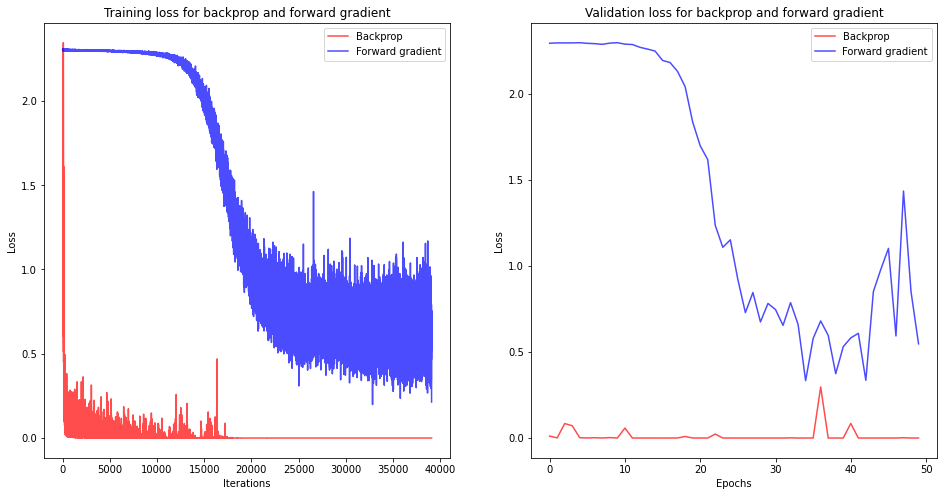

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [20]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-5, -3, 4)
momentums = np.linspace(0.1, 0.9, 4)

epochs = 10

for gamma in learning_rates:
  for momentum in momentums:
    net = CifarNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=1e-6, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, Momentum = {format(momentum,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, Momentum = 0.100000: 2.303
Validation loss for lr = 0.000010, Momentum = 0.366667: 2.303
Validation loss for lr = 0.000010, Momentum = 0.633333: 2.303
Validation loss for lr = 0.000010, Momentum = 0.900000: 2.302
Validation loss for lr = 0.000046, Momentum = 0.100000: 2.303
Validation loss for lr = 0.000046, Momentum = 0.366667: 2.303
Validation loss for lr = 0.000046, Momentum = 0.633333: 2.303
Validation loss for lr = 0.000046, Momentum = 0.900000: 2.303
Validation loss for lr = 0.000215, Momentum = 0.100000: 2.303
Validation loss for lr = 0.000215, Momentum = 0.366667: 2.303
Validation loss for lr = 0.000215, Momentum = 0.633333: 2.302
Validation loss for lr = 0.000215, Momentum = 0.900000: 14.313
Validation loss for lr = 0.001000, Momentum = 0.100000: 2.315
Validation loss for lr = 0.001000, Momentum = 0.366667: 14.294


KeyboardInterrupt: ignored

Searching for best learning rate and momentum for backpropagation.

In [11]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-2, 0, 5)
momentums = np.linspace(0.7, 0.95, 4)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = CifarNet().to(device) # defining net
    backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD
    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, Momentum = {format(momentum,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.010000, Momentum = 0.700000: 1.162
Validation loss for lr = 0.010000, Momentum = 0.783333: 1.182
Validation loss for lr = 0.010000, Momentum = 0.866667: 1.334
Validation loss for lr = 0.010000, Momentum = 0.950000: 1.075
Validation loss for lr = 0.031623, Momentum = 0.700000: 1.251
Validation loss for lr = 0.031623, Momentum = 0.783333: 0.999
Validation loss for lr = 0.031623, Momentum = 0.866667: 1.290
Validation loss for lr = 0.031623, Momentum = 0.950000: 1.321
Validation loss for lr = 0.100000, Momentum = 0.700000: 1.117
Validation loss for lr = 0.100000, Momentum = 0.783333: 1.156
Validation loss for lr = 0.100000, Momentum = 0.866667: 2.307
Validation loss for lr = 0.100000, Momentum = 0.950000: 2.312
Validation loss for lr = 0.316228, Momentum = 0.700000: 2.305
Validation loss for lr = 0.316228, Momentum = 0.783333: 2.304
Validation loss for lr = 0.316228, Momentum = 0.866667: 2.317
Validation loss for lr = 0.316228, Momentum = 0.950000: 2.325
Validati

### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
# for reproducible purposes
torch.manual_seed(42)

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.001000
momentum = 1.637
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: nan
Test loss in epoch 2: nan
Test loss in epoch 3: nan
Test loss in epoch 4: nan
Test loss in epoch 5: nan
Test loss in epoch 6: nan
Test loss in epoch 7: nan
Test loss in epoch 8: nan
Test loss in epoch 9: nan
Test loss in epoch 10: nan
Test loss in epoch 11: nan
Test loss in epoch 12: nan
Test loss in epoch 13: nan
Test loss in epoch 14: nan
Test loss in epoch 15: nan
Test loss in epoch 16: nan
Test loss in epoch 17: nan
Test loss in epoch 18: nan
Test loss in epoch 19: nan
Test loss in epoch 20: nan
Test loss in epoch 21: nan
Test loss in epoch 22: nan
Test loss in epoch 23: nan
Test loss in epoch 24: nan
Test loss in epoch 25: nan


Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.030000
momentum = 0.783
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net
backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.015787575393915176
Test loss in epoch 2: 0.0021923540625721216
Test loss in epoch 3: 0.012933120131492615
Test loss in epoch 4: 0.0043885838240385056
Test loss in epoch 5: 0.018080079928040504
Test loss in epoch 6: 0.001556247123517096
Test loss in epoch 7: 0.02679319493472576
Test loss in epoch 8: 0.0007720048888586462
Test loss in epoch 9: 0.0035625125747174025
Test loss in epoch 10: 0.0015093664405867457
Test loss in epoch 11: 0.1028296947479248
Test loss in epoch 12: 1.1324813158353209e-06
Test loss in epoch 13: 4.7683133743703365e-06
Test loss in epoch 14: 4.573308979161084e-05
Test loss in epoch 15: 7.538141653640196e-05
Test loss in epoch 16: 1.3411033705779118e-07
Test loss in epoch 17: 0.005310583859682083
Test loss in epoch 18: 5.401881935540587e-05
Test loss in epoch 19: 0.039031077176332474
Test loss in epoch 20: 6.201769429026172e-05
Test loss in epoch 21: 6.243384632398374e-06
Test loss in epoch 22: 1.0675915291358251e-05
Test loss in epoch 23: 0.0

#### Comparing results

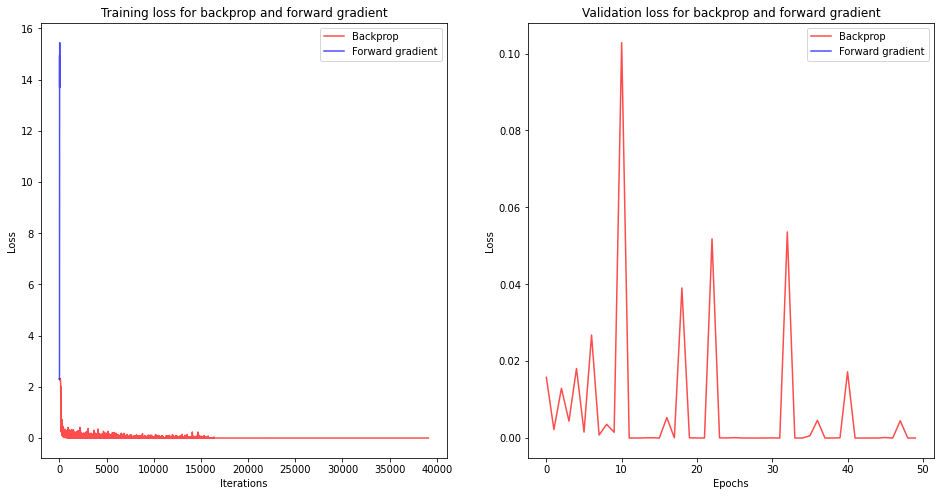

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()